## Clustering Evaluation

### All imports here

In [1]:
import json
import numpy as np
from collections import Counter
from sklearn import metrics
from scipy.special import comb
from scipy.spatial import distance

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [46]:
def parse_distance_matrix(pic_matrix_json):
    """
    parse distance matrix output from pic clustering algorithm
    @arg pic_matrix_json json file containing pic clustering distance
    @return distance dictionary and set of pois
    """
    distance_dict, pois = {}, set()
    for item in pic_matrix_json:
        pois.add(item['poi1'])
        pois.add(item['poi2'])
        if item['poi1'] not in distance_dict.keys():
            distance_dict[item['poi1']] = {item['poi2']: item['distance']}
        else:
            distance_dict[item['poi1']][item['poi2']] = item['distance']
    return distance_dict, pois

def build_distance_matrix(distance_dict, pois):
    """
    build distance matrix from distance dictionary and set of pois, key error should never be thrown here
    @distance_dict contains pairs distance between poi_i and poi_j without duplications, considering (poi_i, poi_j) and (poi_j, poi_i) duplicated
    @pois a list of pois
    @return distance matrix with row sequentially equal to elements in pois
    """
    matrix = []
    for poi_i in pois:  # each row
        row = []
        for poi_j in pois:  # each column
            if poi_i == poi_j:  # if poi_i and poi_j is the same
                row.append(0.0)
            elif poi_i in distance_dict.keys():  # if there is relation between poi_i and poi_j
                if poi_j in distance_dict[poi_i].keys():
                    row.append(distance_dict[poi_i][poi_j])
                else:
                    row.append(distance_dict[poi_j][poi_i])
            else:  # if there is no relation between poi_i and poi_j
                row.append(1.0)
        matrix.append(np.array(row))
    return np.array(matrix)

def parse_clustering_result(clusters_json):
    """
    parse clustering result to get cluster id and corresponding pois in cluster
    """
    clusters = {}
    for cluster in clusters_json['clusters']:
        if cluster['cluster_id'] not in clusters:
            clusters[cluster['cluster_id']] = []
        for poi in cluster['poi_in_cluster']:
            clusters[cluster['cluster_id']].append((poi['poi_id'], poi['categories']['categories']))
    return clusters

def build_label(clusters, pois):
    """
    get cluster label for each poi from clusters and pois
    """
    poi_cluster_label = {}
    for key, value in clusters.items():  # for each cluster_i and pois_in_cluster_i
        for poi in value:  # for each poi(id, categories) in cluster_i
            assert poi[0] not in poi_cluster_label.keys()  # poi shouldn't be labeled, poi assigned to one cluster only
            poi_cluster_label[poi[0]] = key
    
    labels = []
    for poi in pois:  # get cluster label for each poi from poi_cluster dict
        labels.append(poi_cluster_label[poi])
    return np.array(labels)

def build_mds_distance_matrix(poi_coordinates, pois):
    """
    build distance matrix from mds coordinates, so far 2-dimensional space
    """
    mds_matrix = []
    for poi_i in pois:
        row = []
        for poi_j in pois:
            if poi_i == poi_j:
                row.append(0)
            else:
                row.append(distance.euclidean(poi_coordinates[poi_i], poi_coordinates[poi_j]))
        mds_matrix.append(row)
    return np.array(mds_matrix)

def cal_purity(num_pois, categories_in_clusters):
    """
    calculate purity of clustering result
    """
    num_common = 0
    for i, clu in enumerate(categories_in_clusters):
        cluster = categories_in_clusters[i]
        num_common += cluster[max(cluster, key=cluster.get)]   # add the number of most common category in each cluster
    return num_common / num_pois

def cal_nmi(num_pois, clusters, categories, categories_in_clusters):
    """
    calculate normalized mutual information
    """
    print('Number of clusters: ', len(clusters))
    mutual_info = 0
    for i, cluster in enumerate(clusters):
        w_i_card = len(clusters[i])
        for category, c_j_card in categories.items():
            if category in categories_in_clusters[i].keys():
                intersect_w_c = categories_in_clusters[i][category]
                mutual_info += intersect_w_c / num_pois * np.log( (num_pois * intersect_w_c) / (w_i_card * c_j_card) )
    
    h_omega = 0.0
    for i, cluster in enumerate(clusters):
        temp_v = len(clusters[i]) / num_pois
        h_omega += temp_v * np.log(temp_v)
    h_omega = 0.0 - h_omega
    print('Entropy of cluster: ', h_omega)
    
    h_c = 0.0
    for category, c_j_card in categories.items():
        temp_v = c_j_card / num_pois
        h_c += temp_v * np.log(temp_v)
    h_c = 0.0 - h_c
    print('Entropy of classes: ', h_c)
    
    nmi = mutual_info / ((h_omega + h_c) / 2)
    return nmi

def cal_ri(num_poi, clusters, categories, categories_in_clusters):
    """
    cal rand index
    """
    tp_fp = 0  # all pair of pois that are clustered into each cluster
    for i, cluster in enumerate(clusters):
        tp_fp += comb(len(clusters[i]), 2, exact=True)
    print('tp_fp: ', tp_fp)
    
    tp = 0  # pair of same category poi that are assigned into same cluster
    for i, cluster in enumerate(clusters):
        for category, category_num in categories_in_clusters[i].items(): # iterate list
            if category_num > 1:
                tp += comb(category_num, 2, exact=True)
    print('tp: ', tp)
    
    fp = tp_fp - tp
    print('fp: ', fp)
    
    fn_tn = 0
    fn = 0
    for i, category_in_cluster in enumerate(categories_in_clusters):
        cluster = categories_in_clusters[i]
        most_common_category =  max(cluster, key=cluster.get)
        print('most common category: ', most_common_category)
        for category, category_num in cluster.items():
            for j, category_in_cluster2 in enumerate(categories_in_clusters):
                if j > i:
                    if category in categories_in_clusters[j].keys():
                        if category != most_common_category:  # calculate all pois except the one clustered correctly
                            fn_tn += category_num * categories_in_clusters[j][category]     
                        else:  # pair of pois should be clustered into same cluster, but actually not
                            fn += category_num * categories_in_clusters[j][category]  
    print('fn_tn: ', fn_tn)
    print('fn: ', fn)
    tn = fn_tn - fn
    print('tn: ', tn)
    
    ri = (tp + tn) / (tp + tn + fp + fn)
    print('ri: ', ri)
    return tp, fp, fn, ri

def cal_f(tp, fp, fn, beta):
    """
    calculate f measure based on given beta
    """
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    return ((np.power(beta, 2) + 1) * precision * recall) / (np.power(beta, 2) * precision + recall)


def cal_categories(clusters):
    """
    @param clusters contains clustering results
    @return categories - dictionary contains (category, category_num), categories_in_clusters contains (category, category_num) in each cluster
    """
    categories = {}
    categories_in_clusters = []
    for i, cluster in enumerate(clusters):
        categories_in_cluster = {}
        for j, poi in enumerate(clusters[i]):
            category = ' '.join(sorted(poi[1]))
            if category not in categories.keys():
                categories[category] = 1
            else:
                categories[category] += 1
            if category not in categories_in_cluster.keys():
                categories_in_cluster[category] = 1
            else:
                categories_in_cluster[category] += 1
        categories_in_clusters.append(categories_in_cluster)
        print('Number of categories: ', len(categories_in_cluster), ' in cluster ', i)
    print('Number of categories: ', len(categories))
    return categories, categories_in_clusters

def bar_plot(two_d_metrics, algorithms, metrics):
    fig, ax = plt.subplots(figsize=(10, 10))
    num_cols = len(metrics)
    _X = np.arange(len(algorithms))
    width=0.8
    bars = []
    for i in range(num_cols):
        bar = ax.bar(_X - width/2. + i/float(num_cols)*width, two_d_metrics[i], width=width/float(num_cols), align="edge")
        bars.append(bar[0])
    ax.legend(bars, metrics, loc='best', bbox_to_anchor=(1, 0.5))
    plt.xticks(_X, algorithms)
    plt.show()

### PIC

#### silhouette score

In [4]:
with open('../../results/pic_matrix.json') as pic_matrix:
    pic_matrix_json = json.load(pic_matrix)

# get the distance between pois(poi_1, poi_2) and poi_ids(poi_1, poi_2, poi_3, ...)
distance_dict, pois = parse_distance_matrix(pic_matrix_json)

# distance matrix with rows equal to poi in pois sequentially
matrix = build_distance_matrix(distance_dict, pois)

with open('../../results/pic_clusters.json') as pic_clusters:
    pic_clusters_json = json.load(pic_clusters)

# a list of clusters, each cluster containing a list of (poi_id, categories) in the cluster
pic_clusters = parse_clustering_result(pic_clusters_json)

# get the cluster id for each poi in pois get from parse_distance_matrix
labels = build_label(pic_clusters, pois)

pic_silhouette_score = metrics.silhouette_score(matrix, labels, metric='precomputed')
print('pic silhouette score: ', pic_silhouette_score)

pic silhouette score:  0.32597595993289535


#### purity

$$ purity(\Omega, C) = \frac{1}{n} \sum_{k} \max_{j} |\omega_{k} \bigcap c_{j}| $$
$$ \Omega = {\omega_1, \omega_2, ...., \omega_k} $$
$$ C = {c_1, c_2, ..., c_j} $$

In [5]:
pic_categories, pic_categories_in_clusters = cal_categories(pic_clusters)

Number of categories:  478  in cluster  0
Number of categories:  1  in cluster  1
Number of categories:  1  in cluster  2
Number of categories:  1  in cluster  3
Number of categories:  4  in cluster  4
Number of categories:  3  in cluster  5
Number of categories:  8  in cluster  6
Number of categories:  8  in cluster  7
Number of categories:  21  in cluster  8
Number of categories:  36  in cluster  9
Number of categories:  561


In [6]:
num_pois = len(pois)
pic_purity = cal_purity(num_pois, pic_categories_in_clusters)
print('pic purity: ', pic_purity)

pic purity:  0.336026936026936


#### normalized mutual information

$$ I(\Omega;C) = \sum_{k}\sum_{j}P(\omega_k \cap c_j) log \frac{P(\omega_k \cap c_j)}{P(\omega_k)P(c_j)}$$

$$= \sum_{k}\sum_{j}\frac{|\omega_k \cap c_j|}{N} log \frac{N |\omega_k \cap c_j|}{|\omega_k||c_j|}$$,

$$ H(\Omega) = - \sum_{k} P(\omega_k)logP(\omega_k) $$

$$ = - \sum_{k} \frac{|\omega_k|}{N} log \frac{|\omega_k|}{N}$$

$$ NMI(\Omega, C) = \frac{I(\Omega;C)}{[H(\Omega) + H(C)]/2} $$

In [7]:
pic_nmi = cal_nmi(num_pois, pic_clusters, pic_categories, pic_categories_in_clusters)
print('pic nmi: ', pic_nmi)

Number of clusters:  10
Entropy of cluster:  1.9571485303409726
Entropy of classes:  5.023124030478302
pic nmi:  0.5607656472690129


#### rand index

$$ RI = \frac{TP + TN}{TP + FP + FN + TN} $$

In [8]:
pic_tp, pic_fp, pic_fn, pic_ri = cal_ri(num_pois, pic_clusters, pic_categories, pic_categories_in_clusters)

tp_fp:  211601
tp:  47767
fp:  163834
most common category:  Clubs Dance Discotheque@en Diskothek@de Leisure Nachtleben@de Nightlife@en
most common category:  Hotel/Motel@de Hotel/Motel@en Hotel@de Hotel@en Hotels Lodging/Living/Accommodation
most common category:  Austrian Austrian@en Eating & Drinking Restaurant@de Restaurant@en Österreichisch@de
most common category:  Austrian@en Eating & Drinking Hotels Restaurant@de Restaurant@en Österreichisch@de
most common category:  Eating & Drinking Italian Italian@en Italienisch@de Pizza Restaurant@de Restaurant@en
most common category:  Chinese Chinese@en Chinesisch@de Eating & Drinking Restaurant@de Restaurant@en
most common category:  Building@en Gebäude@de Hotels Important Tourist Attraction@en Sehenswürdigkeit@de Tourism
most common category:  Austrian Hotel/Motel@de Hotel/Motel@en Hotel@de Hotel@en Lodging/Living/Accommodation
most common category:  Buildings Denkmal@de Important Tourist Attraction@en Landmarks&Historical Monument@en S

#### f measure

$$ P = \frac{TP}{TP + FP} $$
$$ R = \frac{TP}{TP + FN} $$
$$ F_{\beta} =  \frac{(\beta^2 + 1)PR}{\beta^2 P + R} $$

In [9]:
pic_f = cal_f(pic_tp, pic_fp, pic_fn, 1.5)
print('pic f measure: ', pic_f)

pic f measure:  0.4865373299684167


### MDS

#### silhouette score

In [10]:
with open('../../results/mds_coordinates.json') as mds_coordinates:
    mds_coordinates_json = json.load(mds_coordinates)

poi_coordinates = {}
for item in mds_coordinates_json['coordinates']:
    poi_coordinates[item['poiID']] = (item['coordinate'][0], item['coordinate'][1])

mds_matrix = build_mds_distance_matrix(poi_coordinates, pois)
with open('../../results/mds_kmeans_clusters.json') as mds_kmeans_clusters:
    mds_kmeans_clusters_json = json.load(mds_kmeans_clusters)

mds_clusters = parse_clustering_result(mds_kmeans_clusters_json)
mds_labels = build_label(mds_clusters, pois)

mds_silhouette_score = metrics.silhouette_score(mds_matrix, mds_labels, metric='precomputed')
print('mds silhouette score: ', mds_silhouette_score)

mds silhouette score:  0.8456986105658925


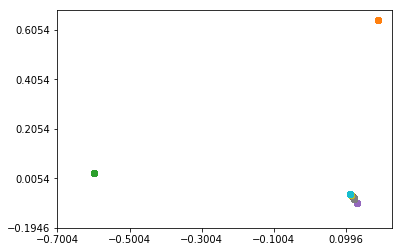

In [11]:
mds_clusters_coordinate = {}
for key, values in mds_clusters.items():
    if key not in mds_clusters_coordinate.keys():
        mds_clusters_coordinate[key] = {'x': [], 'y': []}
    for value in values:
        mds_clusters_coordinate[key]['x'].append(poi_coordinates[value[0]][0])
        mds_clusters_coordinate[key]['y'].append(poi_coordinates[value[0]][1])

NUM_COLORS = len(mds_clusters_coordinate)
fig = plt.figure()  # figsize=(12,12)
ax = fig.add_subplot(111)
min_x, max_x, min_y, max_y = None, None, None, None
for i in range(NUM_COLORS):
    if min_x is None or min_x > min(mds_clusters_coordinate[i]['x']):
        min_x = min(mds_clusters_coordinate[i]['x'])
    if max_x is None or max_x < max(mds_clusters_coordinate[i]['x']):
        max_x = max(mds_clusters_coordinate[i]['x'])
    if min_y is None or min_y > min(mds_clusters_coordinate[i]['y']):
        min_y = min(mds_clusters_coordinate[i]['y'])
    if max_y is None or max_y < max(mds_clusters_coordinate[i]['y']):
        max_y = max(mds_clusters_coordinate[i]['y'])
    ax.scatter(mds_clusters_coordinate[i]['x'], mds_clusters_coordinate[i]['y'])
plt.xticks(np.arange(min_x-0.1, max_x+0.1, step=0.2))
plt.yticks(np.arange(min_y-0.1, max_y+0.1, step=0.2))
plt.show()

#### purity 

In [12]:
mds_categories, mds_categories_in_clusters = cal_categories(mds_clusters)

Number of categories:  424  in cluster  0
Number of categories:  1  in cluster  1
Number of categories:  1  in cluster  2
Number of categories:  3  in cluster  3
Number of categories:  1  in cluster  4
Number of categories:  9  in cluster  5
Number of categories:  31  in cluster  6
Number of categories:  2  in cluster  7
Number of categories:  13  in cluster  8
Number of categories:  76  in cluster  9
Number of categories:  561


In [13]:
mds_purity = cal_purity(num_pois, mds_categories_in_clusters)
print('mds purity: ', mds_purity)

mds purity:  0.3367003367003367


#### normalized mutual information

In [14]:
mds_nmi = cal_nmi(num_pois, mds_clusters, mds_categories, mds_categories_in_clusters)
print('mds nmi: ', mds_nmi)

Number of clusters:  10
Entropy of cluster:  2.045928263760873
Entropy of classes:  5.0231240304782805
mds nmi:  0.578840890858363


#### ri

In [15]:
mds_tp, mds_fp, mds_fn, mds_ri = cal_ri(num_pois, mds_clusters, mds_categories, mds_categories_in_clusters)

tp_fp:  174813
tp:  47767
fp:  127046
most common category:  Austrian Austrian@en Beer Eating & Drinking Garden Gastropubs Restaurant@de Restaurant@en Österreichisch@de
most common category:  Austrian Austrian@en Eating & Drinking Restaurant@de Restaurant@en Österreichisch@de
most common category:  Hotel/Motel@de Hotel/Motel@en Hotel@de Hotel@en Hotels Lodging/Living/Accommodation
most common category:  Eating & Drinking Italian Italian@en Italienisch@de Restaurant@de Restaurant@en
most common category:  Austrian@en Eating & Drinking Hotels Restaurant@de Restaurant@en Österreichisch@de
most common category:  Cafes Café/Pub@de Café/Pub@en Café@de Café@en Coffee&Tea Eating & Drinking
most common category:  Austrian@en Eating & Drinking Restaurant@de Restaurant@en Restaurants Österreichisch@de
most common category:  Chinese Chinese@en Chinesisch@de Eating & Drinking Restaurant@de Restaurant@en
most common category:  Eating & Drinking Indian Indian@en Indisch@de Restaurant@de Restaurant@en

#### f measure

In [16]:
mds_f = cal_f(mds_tp, mds_fp, mds_fn, 1.5)
print('mds f measure: ', mds_f)

mds f measure:  0.5499430990430897


### OneHot Encoding

#### silhouette score

In [17]:
with open('../../results/oneHotMatrix.json') as one_hot:
    one_hot_encoded = json.load(one_hot)

poi_encoding = {}
for item in one_hot_encoded:
    poi_encoding[item[0]] = item[1:]

with open('../../results/oneHot_kmeans_clusters.json') as onehot_kmeans_clusters:
    onehot_kmeans_clusters_json = json.load(onehot_kmeans_clusters)

onehot_matrix, poi_new = [], []
for poi_i, poi_i_code in poi_encoding.items():
    poi_new.append(poi_i)
    row = []
    for poi_j, poi_j_code in poi_encoding.items():
        if poi_i == poi_j:
            row.append(0)
        else:
            row.append(distance.euclidean(poi_i_code, poi_j_code))
    onehot_matrix.append(row)
onehot_matrix = np.array(onehot_matrix)

onehot_clusters = parse_clustering_result(onehot_kmeans_clusters_json)
onehot_labels = build_label(onehot_clusters, poi_new)
onehot_silhouette_score = metrics.silhouette_score(onehot_matrix, onehot_labels, metric='precomputed')
print('one hot silhouette score: ', onehot_silhouette_score)

one hot silhouette score:  0.3053573841536867


#### purity

In [18]:
onehot_categories, onehot_categories_in_clusters = cal_categories(onehot_clusters)

Number of categories:  211  in cluster  0
Number of categories:  49  in cluster  1
Number of categories:  94  in cluster  2
Number of categories:  33  in cluster  3
Number of categories:  62  in cluster  4
Number of categories:  33  in cluster  5
Number of categories:  11  in cluster  6
Number of categories:  22  in cluster  7
Number of categories:  44  in cluster  8
Number of categories:  2  in cluster  9
Number of categories:  561


In [19]:
onehot_purity = cal_purity(num_pois, onehot_categories_in_clusters)
print('one hot purity: ', onehot_purity)

one hot purity:  0.3218855218855219


#### normalized mutual information

In [20]:
onehot_nmi = cal_nmi(num_pois, onehot_clusters, onehot_categories, onehot_categories_in_clusters)
print('one hot nmi: ', onehot_nmi)

Number of clusters:  10
Entropy of cluster:  1.740149951533934
Entropy of classes:  5.023124030478345
one hot nmi:  0.514588040100717


#### ri

In [21]:
onehot_tp, onehot_fp, onehot_fn, onehot_ri = cal_ri(num_pois, onehot_clusters, onehot_categories, onehot_categories_in_clusters)

tp_fp:  259251
tp:  47767
fp:  211484
most common category:  Austrian Austrian@en Eating & Drinking Restaurant@de Restaurant@en Österreichisch@de
most common category:  Hotel/Motel@de Hotel/Motel@en Hotel@de Hotel@en Hotels Lodging/Living/Accommodation
most common category:  Bakeries Essen & Trinken: Bäcker@de Food & Drinks: Bakers@en Geschäft@de Shop@en Shopping
most common category:  Austrian Austrian@en Bars Eating & Drinking Restaurant@de Restaurant@en Wine Österreichisch@de
most common category:  Cafes Café/Pub@de Café/Pub@en Café@de Café@en Coffee&Tea Eating & Drinking
most common category:  Bed & Breakfast & Guest Houses@en Fremdenzimmer & Gästehaus@de Hotel/Motel@de Hotel/Motel@en Hotels Lodging/Living/Accommodation
most common category:  Chinese Chinese@en Chinesisch@de Eating & Drinking Restaurant@de Restaurant@en
most common category:  Austrian Eating & Drinking Nicht spezifiziert@de Restaurant@de Restaurant@en Unspecified@en
most common category:  Bar@de Bar@en Bars Leisure

#### f measure

In [22]:
onehot_f = cal_f(onehot_tp, onehot_fp, onehot_fn, 1.5)
print('onehot f measure: ', onehot_f)

onehot f measure:  0.4233199514352307


### Word2Vec

#### silhouette score

In [23]:
with open('../../results/word2Vec.json') as word2Vec:
    word_vec_encoded = json.load(word2Vec)
    
word_vec_dict = {}
for word_vec in word_vec_encoded:
    word_vec_dict[word_vec['_1']] = word_vec['_2']
    
with open('../../results/word2vec_kmeans_clusters.json') as word2vec_kmeans_clusters:
    word2vec_kmeans_clusters_json = json.load(word2vec_kmeans_clusters)
    
word2vec_clusters = parse_clustering_result(word2vec_kmeans_clusters_json)

word2vec_matrix, poi_word2vec = [], []
for poi_i, poi_i_code in word_vec_dict.items():
    poi_word2vec.append(poi_i)
    row = []
    for poi_j, poi_j_code in word_vec_dict.items():
        if poi_i == poi_j:
            row.append(0)
        else:
            row.append(distance.euclidean(poi_i_code, poi_j_code))
    word2vec_matrix.append(row)
word2vec_matrix = np.array(word2vec_matrix)

word2vec_labels = build_label(word2vec_clusters, poi_word2vec)
word2vec_silhouette_score = metrics.silhouette_score(word2vec_matrix, word2vec_labels, metric='precomputed')
print('word2vec silhouette score: ', word2vec_silhouette_score)

word2vec silhouette score:  0.5559534610129746


#### purity

In [24]:
word2vec_categories, word2vec_categories_in_clusters = cal_categories(word2vec_clusters)

Number of categories:  175  in cluster  0
Number of categories:  10  in cluster  1
Number of categories:  74  in cluster  2
Number of categories:  51  in cluster  3
Number of categories:  76  in cluster  4
Number of categories:  22  in cluster  5
Number of categories:  82  in cluster  6
Number of categories:  6  in cluster  7
Number of categories:  31  in cluster  8
Number of categories:  34  in cluster  9
Number of categories:  561


In [25]:
word2vec_purity = cal_purity(num_pois, word2vec_categories_in_clusters)
print('Word2Vec purity: ', word2vec_purity)

Word2Vec purity:  0.3441077441077441


#### normalized mutual information

In [26]:
word2vec_nmi = cal_nmi(num_pois, word2vec_clusters, word2vec_categories, word2vec_categories_in_clusters)
print('word2vec nmi: ', word2vec_nmi)

Number of clusters:  10
Entropy of cluster:  2.028214379527824
Entropy of classes:  5.023124030478338
word2vec nmi:  0.5752707533224323


#### rand index

In [27]:
w2v_tp, w2v_fp, w2v_fn, w2v_ri = cal_ri(num_pois, word2vec_clusters, word2vec_categories, word2vec_categories_in_clusters)

tp_fp:  169874
tp:  47767
fp:  122107
most common category:  Austrian@en Eating & Drinking Hotels Restaurant@de Restaurant@en Österreichisch@de
most common category:  Hotel/Motel@de Hotel/Motel@en Hotel@de Hotel@en Hotels Lodging/Living/Accommodation
most common category:  Church@en Hotels Kirche@de Place of Worship@en Religiöse Einrichtung@de Tourism
most common category:  Bar@de Bar@en Bars Leisure Nachtleben@de Nightlife@en
most common category:  Bed & Breakfast & Guest Houses@en Fremdenzimmer & Gästehaus@de Hotel/Motel@de Hotel/Motel@en Hotels Lodging/Living/Accommodation
most common category:  Eating & Drinking Italian Italian@en Italienisch@de Restaurant@de Restaurant@en
most common category:  Austrian Austrian@en Eating & Drinking Restaurant@de Restaurant@en Österreichisch@de
most common category:  Bakeries Essen & Trinken: Bäcker@de Food & Drinks: Bakers@en Geschäft@de Shop@en Shopping
most common category:  Café/Pub@de Café/Pub@en Coffee Shop@de Coffee Shop@en Coffee&Tea Eatin

#### f measure

In [29]:
w2v_f = cal_f(w2v_tp, w2v_fp, w2v_fn, 1.5)
print('word2vec f measure: ', w2v_f)

word2vec f measure:  0.5597363978153937


### Comparison

In [34]:
algorithms = ['PIC', 'MDS', 'One-Hot', 'Word2Vec']
metrics = ['Silhouette Score', 'Purity', 'NMI', 'RI', 'F-Measure']
ss_metrics = [pic_silhouette_score, mds_silhouette_score, onehot_silhouette_score, word2vec_silhouette_score]
purity_metrics = [pic_purity, mds_purity, onehot_purity, word2vec_purity]
nmi_metrics = [pic_nmi, mds_nmi, onehot_nmi, word2vec_nmi]
ri_metrics = [pic_ri, mds_ri, onehot_ri, w2v_ri]
f_metrics = [pic_f, mds_f, onehot_f, w2v_f]

In [35]:
two_d_metrics = [ss_metrics, purity_metrics, nmi_metrics, ri_metrics, f_metrics]

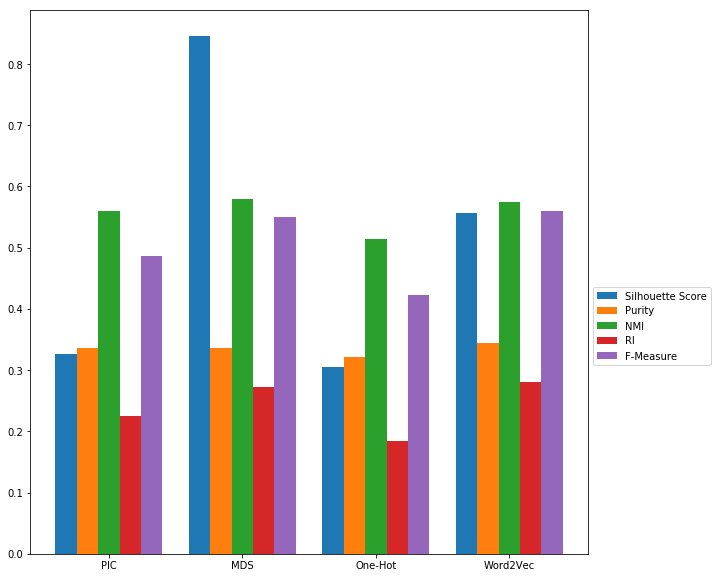

In [47]:
bar_plot(two_d_metrics, algorithms, metrics)